# Detecting NYC Traffic Anomalies EDA Notebook

This notebook will walk through the EDA process I used to explore and clean the traffic data from [NYC open data](https://data.cityofnewyork.us/Transportation/DOT-Traffic-Speeds-NBE/i4gi-tjb9). At the end of this notebook you will have a better understand of the data being worked with and you will also have cleaned data that you can use for modeling in the next notebook.

### Libraries Needed

In [191]:
#import required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import folium
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows',10)

### Custom Functions Needed

In [1396]:
# Import the check_stationarity function
def stationarity_check(TS, plot = True, return_pvalue = False):
    """
    Checks the stationarity of a timeseries
    """
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    if plot:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
        std = plt.plot(roll_std, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    else:
        pass
    # Print Dickey-Fuller test results
    if return_pvalue:
        return dftest[1]
    else:
        print('Results of Dickey-Fuller Test: \n')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                                 '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    
        return None

In [4]:
def inside_poly(x, y, poly):
    """
    This function determines if a coordinate is inside of a polygon using the ray method.
    The basic idea is that you draw a line in the same direction for all points and count how many times
    the line crosses the sides of the polygon. If it is an odd number of times then point is inside the
    polygon, and conversely if it is an even number than it is outside the polygon.
    
    x: x-coordinate of the point in question
    y: y-coordinate of the point in question
    poly: array of tuples that have the x,y coordinate of each vertex that makes up the polygon
    """
    #seperate x,y coordinates of the polygon
    x_polys = [x[0] for x in poly]
    y_polys = [y[1] for y in poly]
    
    #initiate the current vertex(i) and the previous vertex(j) and c which is a variable that toggles if a line
    #of the polygon is crossed
    i = 0
    j = len(x_polys) - 1
    c = False
    
    #while all of the sides have not been checked keep runnning the following the code
    while i < len(x_polys):
        #essentially if the side being evalutated can be crossed because of its location relative to the point
        #then toggle that it crossed a side
        if ((y < y_polys[i]) != (y < y_polys[j])):
            #if the ray crosses a side then toggle c and increment to the next vertexes
            if (x < ((x_polys[j] - x_polys[i]) * (y - y_polys[i]) / (y_polys[j] - y_polys[i])) + x_polys[i]):
                c = not c
                j = i
                i += 1
            #else it doesn't cross the side, so increment to the next vertexes
            else:
                j = i
                i += 1
                continue
        #else the side cannot be crossed, so increment to the next vertexes
        else:
            j = i
            i += 1
            continue
    #return the value of c(true=inside polygon false=outside)
    return c

In [5]:
def roundtime(dt=None, roundto=1):
    """
    Round a datetime object to a time lapse in minutes with max being the nearest hour
    dt : datetime.datetime object, default now.
    roundto : Closest minute to round to, default 1 minute. max = 60
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    #check to make sure the function is able to round to the next specified interval
    if 60 < roundto:
        print('error: roundto is greater than 60')
        return None
    #if no datetime is entered take the time it is currently
    if dt == None:
        dt = datetime.datetime.now()
    
    #find out how many minutes into the hour the inputted time is
    minutes = dt.minute
    #find out how many seconds into the hour the inputted time is
    seconds = dt.second
    #calculate how many seconds until the next interval specified there are
    rem = (minutes * 60 + seconds) % (roundto * 60)
    
    #if there are x number of seconds until the next interval then do the following
    if rem != 0:
        #return the datetime of the next interval
        return dt.replace(microsecond=0) + datetime.timedelta(seconds = (roundto * 60 - rem))
    #input datetime is at an interval, so return the input datetime
    return dt

In [57]:
def day_of_week_agg(df):
    """
    Takes in a dataframe with an index of datetimes and groups the rows by the day of the week and then
    averages the each column for all of the rows by the hour and minute in that groups.
    The output of this function is a list of dataframes. One dataframe for each day of the week.
    """
    #create an array of integers with the value equal to the day of the week for that row (0=Monday, 6=Sunday)
    int_array = df.apply(lambda x: x.name.weekday(), axis = 1)
    #instantiate an empty list
    day_dfs = []
    
    #for each day of the week do the following
    for i in range(7):
        # make a new dataframe of only the rows with the day of the week i
        day = df[(int_array == i)]
        # average the data based on the minute of the day
        day_agg = day.groupby([day.index.hour, day.index.minute]).mean()
        # append the aggregated dataframe to a list
        day_dfs.append(day_agg)
    #return the list of aggregated dataframes
    return day_dfs

In [382]:
def standardize_df(dataframe, column, X_steps, y_steps, num_train_sets, num_val_sets):
    """
    This function standardizes the data of a column.
    
    dataframe: dataframe to standarize
    column: the column in the dataframe to standardize
    X_steps: the number of rows used to train on
    y_steps: the number of rows used to test on
    num_train_sets: the number of training sets there are for this dataframe
    """
    #import needed libraries
    from sklearn.preprocessing import StandardScaler
    
    #slice the dataframe down to the column to be scaled
    df = pd.DataFrame(dataframe[column])
    
    # initialize the standard scaler
    scaler = StandardScaler()
    #train the standard scaler on the rows that will be in the training set
    scaler = scaler.fit(df.iloc[:(num_train_sets * (X_steps + y_steps))])
    
    # standardize the dataframe
    train_standardized = pd.DataFrame(scaler.transform(df.iloc[:(num_train_sets * (X_steps + y_steps))]), columns=[column])
    val_standardized = pd.DataFrame(scaler.transform(df.iloc[(num_train_sets * (X_steps + y_steps)) : ((num_train_sets + num_val_sets) * (X_steps + y_steps))]), columns=[column])
    test_standardized = pd.DataFrame(scaler.transform(df.iloc[((num_train_sets + num_val_sets) * (X_steps + y_steps)):]), columns=[column])
    
    # return the standardized dataframe
    return pd.concat([train_standardized, val_standardized, test_standardized])

In [ ]:
def train_val_test_dfs(dataframe, column, X_steps=50, y_steps=1, val_size=0.2, test_size=0.1, standardize=False):
    num_sets = len(dataframe) // (X_steps + y_steps)
    offset = (len(dataframe) % (X_steps + y_steps)) - 1
    num_val_sets = int(num_sets * val_size)
    num_test_sets = int(num_sets * test_size)
    num_train_sets = num_sets - num_val_sets - num_test_sets
    
    if standardize:
        df = standardize_df(dataframe, column, X_steps, y_steps, num_train_sets, num_val_sets)
    else:
        df = dataframe.copy()
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(num_sets):
        if i < num_train_sets:
            X_train.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_train.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        elif i < (num_train_sets + num_val_sets):
            X_val.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_val.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        else:
            X_test.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_test.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

In [881]:
def last_x_yrs_5min_samp_df(years):
    """
    This function takes in the amount of years and outputs a dataframe of
    datetimes of a 5min sampling rate for the amount of years wanted
    
    years: array of years you want to calculate for
    """
    import calendar
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    datetime_array = []
    for year in years:
        if calendar.isleap(year):
            d_p_m = days_per_month_leap
        else:
            d_p_m = days_per_month
        for month in range(1,13):
            for day in range(1,d_p_m[month-1]+1):
                for hour in range(24):
                    for minute in range(0,60,5):
                         datetime_array.append(datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    return pd.DataFrame(datetime_array, columns=['date'])

---

## EDA

In [6]:
#read in data
data = pd.read_csv('DOT_Traffic_Speeds_NBE.csv')

In [7]:
data.shape

(42736589, 13)

Our data has more than 4.27 million observations and 13 features

In [8]:
#number of nulls per column
data.isnull().sum()

ID                        0
SPEED                     0
TRAVEL_TIME               0
STATUS                    0
DATA_AS_OF                0
LINK_ID                   0
LINK_POINTS               0
ENCODED_POLY_LINE         0
ENCODED_POLY_LINE_LVLS    0
OWNER                     0
TRANSCOM_ID               0
BOROUGH                   0
LINK_NAME                 0
dtype: int64

Great this data came clean! That is a big surprise and very helpful.

In [9]:
#check out the datatype in each column
data.dtypes

ID                          int64
SPEED                     float64
TRAVEL_TIME                 int64
STATUS                      int64
DATA_AS_OF                 object
LINK_ID                     int64
LINK_POINTS                object
ENCODED_POLY_LINE          object
ENCODED_POLY_LINE_LVLS     object
OWNER                      object
TRANSCOM_ID                 int64
BOROUGH                    object
LINK_NAME                  object
dtype: object

In [10]:
#lets look at the data
data.head()

ID  SPEED  TRAVEL_TIME  STATUS              DATA_AS_OF  LINK_ID  \
0  165  51.57           49       0  01/11/2020 10:28:05 PM  4616305   
1  313  52.19          293       0  01/11/2020 10:28:05 PM  4616365   
2  453  43.49          127       0  01/11/2020 10:28:12 PM  4616239   
3  167  55.92          115    -101  01/11/2020 10:28:12 PM  4616312   
4  212  54.05          201       0  01/11/2020 10:29:03 PM  4362244   

                                         LINK_POINTS  \
0  40.81477,-73.83629 40.81611,-73.83627 40.81784...   
1  40.74138001,-73.95405001  40.74127,-73.9522200...   
2  40.7714206,-73.83345 40.7702704,-73.8354 40.76...   
3  40.7992604,-73.828251 40.79751,-73.827091 40.7...   
4  40.78802,-73.79003 40.7868604,-73.78838 40.786...   

                                   ENCODED_POLY_LINE  \
0                       isbxFxctaMkGCyIs@_NWgVb@iF`@   
1  shtwFxckbMTmJ_AiK?}BvAwNlBsNrCqJ`GoQjAcFl@mE~@...   
2  kdzwF`rsaMdFdKlEdGzIvHzHdEvAv@rBz@bATjAJdBAhAK...   
3  kr_xFpqraM\\\\\\|IgFfJaGbNaIjCqAtDw@vDOlLf@xHf...   
4  cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@\\\\\\|BcAvB...   

                              ENCODED_POLY_LINE_LVLS              OWNER  \
0                                             BBBBBB        NYC_DOT_LIC   
1    BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB        NYC_DOT_LIC   
2                                       BBBBBBBBBBBB        NYC_DOT_LIC   
3                                BBBBBBBBBBBBBBBBBBB        NYC_DOT_LIC   
4  BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...  NYC-DOT-Region 10   

   TRANSCOM_ID BOROUGH                                          LINK_NAME  
0      4616305   Bronx             BWB N Toll Plaza - HRP N Lafayatte Ave  
1      4616365  Queens                     LIE E QMT TOLL PLAZA - 84TH ST  
2      4616239  Queens  Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...  
3      4616312  Queens  BWB S Queens Anchorage - WSE S Exit 14 (Linden...  
4      4362244  Queens                       CVE NB LIE - WILLETS PT BLVD

As you can see the data as of column is a date column but the dtype is object. Lets change the column to a datetime.

In [11]:
#Change to datetime
data['DATA_AS_OF'] = pd.to_datetime(data['DATA_AS_OF'], format='%m/%d/%Y %I:%M:%S %p')

There are few things to note after looking at the data dictionary for this dataset which can be found [here](https://data.cityofnewyork.us/Transportation/DOT-Traffic-Speeds-NBE/i4gi-tjb9) under attachments.
1. There are a few outdated/redundant columns
    - STATUS (artifact according to the data dictionary)
    - LINK_ID (same meaning as ID column according to the data dictionary)
    - TRANSCOM_ID (artifact according to the data dictionary)
2. There are a few columns that won't be useful for this application
    - TRAVEL_TIME (we don't need to know how long it took on avg to cross the sensor field)
    - ENCODED_POLY_LINE (we won't use polylines)
    - ENCODED_POLY_LINE_LVLS (we won't use polylines)
    
Lets get rid of the columns that we won't be using

In [1140]:
df = data.drop(columns=['STATUS', 'LINK_ID', 'TRANSCOM_ID', 'TRAVEL_TIME', 'ENCODED_POLY_LINE', 'ENCODED_POLY_LINE_LVLS'])
df.head()

ID  SPEED          DATA_AS_OF  \
0  165  51.57 2020-01-11 22:28:05   
1  313  52.19 2020-01-11 22:28:05   
2  453  43.49 2020-01-11 22:28:12   
3  167  55.92 2020-01-11 22:28:12   
4  212  54.05 2020-01-11 22:29:03   

                                         LINK_POINTS              OWNER  \
0  40.81477,-73.83629 40.81611,-73.83627 40.81784...        NYC_DOT_LIC   
1  40.74138001,-73.95405001  40.74127,-73.9522200...        NYC_DOT_LIC   
2  40.7714206,-73.83345 40.7702704,-73.8354 40.76...        NYC_DOT_LIC   
3  40.7992604,-73.828251 40.79751,-73.827091 40.7...        NYC_DOT_LIC   
4  40.78802,-73.79003 40.7868604,-73.78838 40.786...  NYC-DOT-Region 10   

  BOROUGH                                          LINK_NAME  
0   Bronx             BWB N Toll Plaza - HRP N Lafayatte Ave  
1  Queens                     LIE E QMT TOLL PLAZA - 84TH ST  
2  Queens  Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...  
3  Queens  BWB S Queens Anchorage - WSE S Exit 14 (Linden...  
4  Queens                       CVE NB LIE - WILLETS PT BLVD

In [1333]:
df = df[df['DATA_AS_OF'] >= '2017']

Lets look at data only from the last 3 years. Let's see if all the sensors have the same amount of data.

In [1334]:
df['ID'].value_counts()

184    317426
1      317423
185    317422
129    317412
207    317406
426    317398
208    317385
331    317385
427    317376
315    317376
258    317375
2      317375
4      317361
257    317360
422    317360
145    317333
259    317332
150    317330
332    317294
3      317288
169    317288
153    317287
159    317286
155    317221
199    317157
450    317111
126    317065
172    317064
428    317062
178    317057
453    317044
425    317020
154    317009
149    317003
110    316875
423    316867
424    316867
167    316853
338    316825
171    316809
430    316796
434    316795
433    316794
431    316794
223    316752
215    316703
170    316702
412    316639
142    316582
177    316580
413    316470
165    316446
419    316400
106    316371
222    316343
385    316327
387    316326
295    316302
221    316105
388    315713
418    315699
394    315638
212    315598
319    315592
204    315589
217    315537
369    315374
351    315363
211    315357
262    315303
318    315233
311   

It looks like most of them are recording similar amounts of observations, and a few aren't. Let's make sure they aren't new sensors before we get rid of them.

In [1335]:
#get IDs of the sensors with < 100k observations
sensors_below_100k = pd.Series((df['ID'].value_counts() < 100000)[lambda x: x].index)
for ID in sensors_below_100k:
    min_date, max_date = df[df['ID'] == ID]['DATA_AS_OF'].min(), df[df['ID'] == ID]['DATA_AS_OF'].max()
    print(f'Sensor:{ID}  Most recent date: {max_date}  Earliest date: {min_date}')

Sensor:148  Most recent date: 2020-10-27 22:42:04  Earliest date: 2017-02-28 08:33:54
Sensor:157  Most recent date: 2020-10-27 22:42:04  Earliest date: 2017-02-22 11:54:47


It looks like these sensors are recording a proportional amount. We won't drop them.

In [1175]:
df['ID'].value_counts()

184    317426
1      317423
185    317422
129    317412
207    317406
426    317398
208    317385
331    317385
427    317376
315    317376
258    317375
2      317375
4      317361
257    317360
422    317360
145    317333
259    317332
150    317330
332    317294
3      317288
169    317288
153    317287
159    317286
155    317221
199    317157
450    317111
126    317065
172    317064
428    317062
178    317057
453    317044
425    317020
154    317009
149    317003
110    316875
423    316867
424    316867
167    316853
338    316825
171    316809
430    316797
434    316796
433    316795
431    316795
223    316752
215    316703
170    316702
412    316639
142    316582
177    316580
413    316470
165    316446
419    316400
106    316371
222    316343
385    316327
387    316326
295    316302
221    316105
388    315714
418    315699
394    315638
212    315599
319    315593
204    315589
217    315537
369    315375
351    315364
211    315358
262    315303
318    315234
311   

Perfect, now lets dive into the data a bit more.

In [1336]:
df[(df['DATA_AS_OF'] >= '2020-01-11') & (df['DATA_AS_OF'] < '2020-01-12') & (df['ID'] == 1)].sort_values(by=['DATA_AS_OF'])

ID  SPEED          DATA_AS_OF  \
42698876   1   9.94 2020-01-11 00:03:11   
42699014   1  10.56 2020-01-11 00:08:12   
42699180   1   9.94 2020-01-11 00:13:11   
42699300   1  10.56 2020-01-11 00:18:11   
42699459   1  13.67 2020-01-11 00:23:12   
42699573   1  11.18 2020-01-11 00:28:11   
42699757   1  10.56 2020-01-11 00:33:13   
42699865   1  11.18 2020-01-11 00:38:10   
42700043   1  11.80 2020-01-11 00:43:12   
42700180   1  13.67 2020-01-11 00:48:12   
42700317   1  12.42 2020-01-11 00:53:10   
42700456   1  11.80 2020-01-11 00:58:11   
42700601   1  11.18 2020-01-11 01:03:11   
42700735   1  11.80 2020-01-11 01:08:11   
42700875   1  12.42 2020-01-11 01:11:11   
42700960   1  10.56 2020-01-11 01:18:10   
42701173   1   8.07 2020-01-11 01:24:11   
42701220   1  10.56 2020-01-11 01:28:11   
42701376   1  16.15 2020-01-11 01:33:11   
42701521   1  15.53 2020-01-11 01:38:10   
42701730   1  10.56 2020-01-11 01:44:11   
42701872   1  11.80 2020-01-11 01:49:11   
42702012   1  11.18 2020-01-11 01:54:11   
42702077   1   9.94 2020-01-11 01:58:12   
42702279   1  11.80 2020-01-11 02:04:11   
42702334   1  11.80 2020-01-11 02:08:11   
42702492   1  13.67 2020-01-11 02:13:10   
42702623   1  15.53 2020-01-11 02:18:11   
42702831   1   9.32 2020-01-11 02:24:12   
42702878   1  10.56 2020-01-11 02:28:11   
42703034   1   9.32 2020-01-11 02:33:13   
42703168   1   6.83 2020-01-11 02:38:10   
42703385   1  17.39 2020-01-11 02:49:12   
42703525   1  14.91 2020-01-11 02:54:11   
42703596   1   8.07 2020-01-11 02:58:11   
42703708   1   9.32 2020-01-11 03:03:11   
42703870   1  11.18 2020-01-11 03:08:10   
42704068   1  14.29 2020-01-11 03:14:10   
42704220   1  14.91 2020-01-11 03:19:11   
42704359   1  12.42 2020-01-11 03:24:12   
42704500   1  13.67 2020-01-11 03:29:10   
42704637   1  18.01 2020-01-11 03:34:11   
42704775   1   9.32 2020-01-11 03:39:12   
42704915   1   6.83 2020-01-11 03:44:11   
42704979   1   8.07 2020-01-11 03:48:10   
42705122   1   3.72 2020-01-11 03:53:10   
42705331   1   4.97 2020-01-11 03:59:11   
42705375   1  14.29 2020-01-11 04:03:11   
42705607   1   9.94 2020-01-11 04:09:11   
42705674   1   3.72 2020-01-11 04:13:12   
42705813   1  18.01 2020-01-11 04:18:11   
42706036   1  19.26 2020-01-11 04:24:10   
42706163   1  14.91 2020-01-11 04:29:11   
42706314   1   8.69 2020-01-11 04:34:11   
42706383   1   9.94 2020-01-11 04:38:12   
42706592   1  11.18 2020-01-11 04:44:11   
42706654   1  15.53 2020-01-11 04:48:11   
42706794   1  14.91 2020-01-11 04:53:11   
42706947   1  15.53 2020-01-11 04:58:12   
42707079   1  18.64 2020-01-11 05:03:13   
42707224   1  19.88 2020-01-11 05:08:12   
42707354   1  19.88 2020-01-11 05:13:11   
42707505   1  19.26 2020-01-11 05:18:11   
42707699   1  18.01 2020-01-11 05:24:12   
42707842   1  13.67 2020-01-11 05:29:12   
42707909   1  11.18 2020-01-11 05:33:12   
42708047   1  17.39 2020-01-11 05:38:12   
42708181   1  18.01 2020-01-11 05:43:11   
42708320   1  12.42 2020-01-11 05:48:11   
42708539   1  18.64 2020-01-11 05:54:11   
42708680   1  18.64 2020-01-11 05:59:12   
42708821   1  18.01 2020-01-11 06:04:12   
42708960   1  18.01 2020-01-11 06:09:12   
42709101   1  17.39 2020-01-11 06:14:11   
42709179   1  17.39 2020-01-11 06:18:12   
42709319   1  18.64 2020-01-11 06:23:12   
42709455   1  18.01 2020-01-11 06:28:11   
42709580   1  19.26 2020-01-11 06:33:11   
42709734   1  19.26 2020-01-11 06:38:11   
42709869   1  18.01 2020-01-11 06:43:13   
42710010   1  17.39 2020-01-11 06:48:10   
42710159   1  16.77 2020-01-11 06:53:11   
42710283   1  16.77 2020-01-11 06:58:11   
42710427   1  17.39 2020-01-11 07:03:11   
42710574   1  16.15 2020-01-11 07:08:11   
42710784   1  16.15 2020-01-11 07:14:10   
42710928   1  16.77 2020-01-11 07:19:11   
42711001   1  16.15 2020-01-11 07:22:10   
42711207   1  16.77 2020-01-11 07:29:12   
42711348   1  11.80 2020-01-11 07:34:11   
42711496   1  12.42 2020-01-11 07:39:12   
42711559   1  15.53 2020-01-11 07:43:11   
42711776   

It appears that the sensor is sampling every 5 minutes. Let's see if this is the case for all the sensors.

In [1337]:
#group by ID and in 24hour intervals
df.groupby(['ID', pd.Grouper(key='DATA_AS_OF', freq='D')])['DATA_AS_OF'].agg(['count']).groupby(['ID']).agg(['mean'])

count
           mean
ID             
1    260.824158
2    260.784717
3    260.713229
4    260.773213
106  260.173520
110  260.373870
119  259.791246
124  262.748508
126  260.958848
129  260.815119
137  262.886288
140  259.434243
141  260.423333
142  260.990932
145  260.750205
148  239.869231
149  260.479047
150  260.533662
153  260.712408
154  260.698191
155  260.658176
157  239.866667
159  260.925987
160  262.234804
164  260.566667
165  261.309661
167  261.214345
168  259.883181
169  260.927632
170  261.089860
171  260.962932
172  260.529170
177  260.345395
178  260.952263
184  260.826623
185  260.823336
186  256.104699
190  258.772465
191  258.755153
195  258.045380
199  260.605588
202  259.508699
204  259.744033
205  265.662661
206  265.489270
207  260.810189
208  260.792933
211  259.553086
212  259.751440
213  259.412593
215  261.090684
217  260.344059
221  260.597692
222  260.364609
223  260.486842
257  260.772391
258  260.784717
259  260.749384
261  259.725620
262  259.508642
263  258.903494
264  259.985892
265  259.117745
295  261.406612
298  259.530680
311  259.805441
315  260.785538
318  260.308010
319  259.746502
324  256.949628
325  258.235974
329  257.452736
330  258.196370
331  260.792933
332  260.932566
338  261.191261
344  258.750206
345  257.934818
347  260.420000
349  264.099656
350  265.606838
351  259.771829
354  266.103863
364  260.128631
365  265.036176
369  259.780890
375  265.682906
376  265.679487
377  265.714530
378  265.711966
379  258.250000
380  259.125104
381  265.684615
382  266.458369
383  266.459227
384  266.453219
385  260.995875
387  260.995050
388  260.060132
390  260.814784
394  260.642444
395  259.766749
398  260.482068
399  260.189926
402  259.958333
405  264.329352
406  259.587552
410  259.534768
411  259.450786
412  261.253300
413  261.113861
416  259.505385
417  259.713930
418  260.692816
419  260.840890
422  260.772391
423  260.367297
424  260.367297
425  260.707237
426  260.803615
427  260.785538
428  260.527527
430  260.308956
431  260.307313
433  260.307313
434  260.308135
435  265.708547
436  266.452361
437  266.450644
439  266.454077
440  257.663644
441  266.450644
445  258.508757
448  258.264633
450  260.567790
451  259.717122
453  260.512736

There are on average ~260 readings per sensor per day. This breaks down to a 5.5 minute sampling interval. However, if you look at the datetime values it looks like the sampling rate is really 5 min, but we just have missing intervals. We will have to interpolate these missing values. First we need to add a column to the dataset that has datetimes of the nearest 5 minute interval the row should belong to.

In [1338]:
df['rounded_timestamp'] = df['DATA_AS_OF'].apply(lambda x: roundtime(x, 5))

Now lets seperate the data into dataframes grouped by sensor and set the index to the rounded timestamp and start interpolating

In [1339]:
sensor_dfs = {}
for sensor in df.ID.unique():
    sensor_dfs[sensor] = df[lambda x: x['ID'] == sensor].sort_values(by=['rounded_timestamp'])

In [1340]:
sensor_dfs[205]

ID  SPEED          DATA_AS_OF  \
10170197  205  52.19 2017-08-11 15:33:09   
10170384  205  50.95 2017-08-11 15:38:10   
10170474  205  49.70 2017-08-11 15:43:10   
10170644  205  49.08 2017-08-11 15:48:08   
10170830  205  49.70 2017-08-11 15:53:10   
...       ...    ...                 ...   
9396881   205  51.57 2020-10-27 22:09:04   
9397027   205  59.03 2020-10-27 22:18:04   
9397160   205  59.65 2020-10-27 22:25:04   
9397294   205  59.03 2020-10-27 22:33:04   
9397428   205  36.03 2020-10-27 22:41:03   

                                                LINK_POINTS  \
10170197  40.78819,-73.79052 40.7887906,-73.78895 40.789...   
10170384  40.78819,-73.79052 40.7887906,-73.78895 40.789...   
10170474  40.78819,-73.79052 40.7887906,-73.78895 40.789...   
10170644  40.78819,-73.79052 40.7887906,-73.78895 40.789...   
10170830  40.78819,-73.79052 40.7887906,-73.78895 40.789...   
...                                                     ...   
9396881   40.78819,-73.79052 40.7887906,-73.78895 40.789...   
9397027   40.78819,-73.79052 40.7887906,-73.78895 40.789...   
9397160   40.78819,-73.79052 40.7887906,-73.78895 40.789...   
9397294   40.78819,-73.79052 40.7887906,-73.78895 40.789...   
9397428   40.78819,-73.79052 40.7887906,-73.78895 40.789...   

                      OWNER BOROUGH         LINK_NAME   rounded_timestamp  
10170197  NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2017-08-11 15:35:00  
10170384  NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2017-08-11 15:40:00  
10170474  NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2017-08-11 15:45:00  
10170644  NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2017-08-11 15:50:00  
10170830  NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2017-08-11 15:55:00  
...                     ...     ...               ...                 ...  
9396881   NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2020-10-27 22:10:00  
9397027   NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2020-10-27 22:20:00  
9397160   NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2020-10-27 22:30:00  
9397294   NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2020-10-27 22:35:00  
9397428   NYC-DOT-Region 10  Queens  CIP NB GCP - TNB 2020-10-27 22:45:00  

[309497 rows x 8 columns]

In [1341]:
#turn sensor dfs into dataframes with rows for all the missing time 5min time periods
years = list(range(2015,2021))
sampling_df = last_x_yrs_5min_samp_df(years)
for sens,sens_df in sensor_dfs.items():
    sens_sampling_df = sampling_df[(sampling_df.date >= sens_df.head(1)['rounded_timestamp'].iloc[0]) & (sampling_df.date <= sens_df.tail(1)['rounded_timestamp'].iloc[0])]
    sens_clean = pd.merge(left = sens_sampling_df, right = sens_df, how = 'left', left_on='date', right_on='rounded_timestamp').set_index('date')
    sensor_dfs[sens] = sens_clean

In [1345]:
#calculate how many nulls each sensor has
nulls = []
for sens,sens_df in sensor_dfs.items():
    nulls.append([sens, sens_df['SPEED'].isnull().sum()])
nulls_df = pd.DataFrame(nulls)
nulls_df.sort_values(by=0)

0       1
118    1   50175
114    2   50202
61     3   50199
119    4   50218
60   106   51144
106  110   51142
18   119   58056
17   124   54326
52   126   50036
51   129   49656
55   137   61423
13   140   53826
12   141   54879
56   142   50553
123  145   50314
101  148  291917
120  149   50054
121  150   49725
97   153   49772
95   154   50042
96   155   49851
104  157  293611
99   159   49965
103  160   52310
70   164   54109
0    165   51628
2    167   51188
69   168   53134
65   169   50068
66   170   50675
128  171   50711
112  172   50854
111  177   51342
107  178   50214
100  184   49854
88   185   49849
77   186   58180
80   190   54559
79   191   54568
75   195   56527
125  199   50328
15   202   53997
113  204   51288
4    205   28966
8    206   29181
126  207   50081
124  208   50132
6    211   51488
3    212   51264
9    213   53670
116  215   50933
115  217   52097
117  221   51515
62   222   51269
122  223   50848
58   257   49644
49   258   49615
94   259   49712
50   261   52750
59   262   51885
30   263   56136
28   264   54066
74   265   56623
53   295   50849
16   298   54588
72   311   52977
129  315   49486
5    318   51599
7    319   51265
32   324   57811
31   325   56288
35   329   58513
34   330   56346
127  331   50113
64   332   50152
54   338   50210
78   344   54808
76   345   56263
11   347   54887
33   349   74821
41   350   90044
89   351   51745
136  354   29704
22   364   53323
21   365   30637
40   369   52639
38   375   89876
37   376   89875
81   377   89869
82   378   89885
25   379   55332
23   380   54500
39   381   89859
93   382   28180
48   383   28143
84   384   28191
45   385   50536
44   387   50547
90   388   51308
87   390   52881
131  394   52512
10   395   52736
14   398   54426
36   399   51607
19   402   56649
130  405   71347
20   406   55784
29   410   53281
27   411   53146
134  412   51400
135  413   51570
26   416   53570
24   417   53575
133  418   52359
132  419   51642
108  422   50116
109  423   50645
110  424   50618
57   425   50320
105  426   50070
102  427   50093
98   428   50432
46   430   50166
47   431   50171
92   433   50266
91   434   50201
83   435   89911
43   436   28173
86   437   28268
85   439   28200
73   440   75489
42   441   28175
68   445   57958
67   448   55345
63   450   50775
71   451   53759
1    453   51078

For some sensors a majority of the values are missing between their earliest recording time and their latest. We will need to get rid of these sensors.

In [1346]:
drop_sensors = nulls_df[lambda x: x[1] > 100000][0]

In [1349]:
for sensor in drop_sensors:
    del sensor_dfs[sensor]

Now we are ready to interpolate the missing values for the remaining sensors

In [1353]:
#fill the missing values using interpolate
for sens,sens_df in tqdm.tqdm(sensor_dfs.items()):
    sensor_dfs[sens] = sens_df.interpolate().ffill()

100%|██████████| 135/135 [32:20<00:00, 14.37s/it]


Additionally we want to get rid of all the zero values, because they are not possible. Most likely they indicate that no cars have gone through in a while or the sensor messed up. Either way we will use the previous values to fill them. This will also help make our model more sensitive to outliers which will be helpful.

In [ ]:
#fill the speed column values of 0 with the previous value. This is to make our model more sensitive to outliers for anomaly detection
for sens,sens_df in tqdm.tqdm(sensor_dfs.items()):
    condition = [sens_df['SPEED'] == 0]
    choices = [np.nan]
    sens_df['SPEED'] = np.select(condition, choices, default=sens_df['SPEED'])
    sens_df.fillna(method = 'ffill', inplace = True)
    sensor_dfs[sens] = sens_df

Great, now lets look at the stationarity of the data. We will look at a random sensor. Because of the number of datapoints visualization is crowded and doesn't reveal much. To get a general idea of the data we will resample it in daily intervals. However, we will still test the stationarity on the whole dataset.

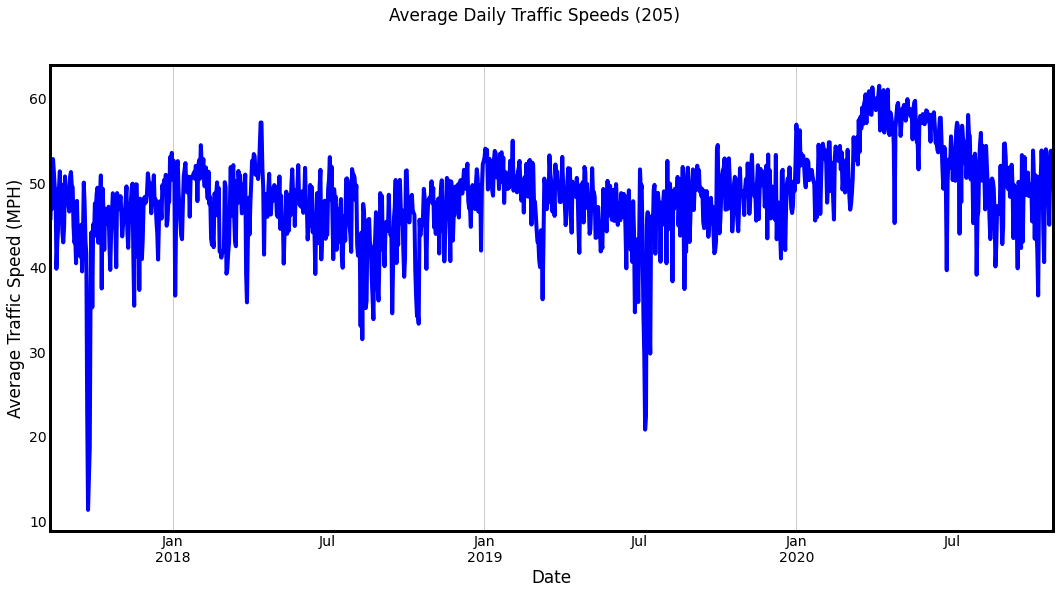

In [1387]:
# # Group the time series into weekly buckets to make visualization easier
sens_weekly = sensor_dfs[205]['SPEED'].resample('D')

# Take the mean of each group 
sens_weekly_mean = sens_weekly.mean()

#plot the generic trend and save the figure
fig1, ax1 = plt.subplots(figsize=(16,8))
sens_weekly_mean.plot(color='blue', ax=ax1);
fig1.set_facecolor('white')
fig1.suptitle('Average Daily Traffic Speeds (205)')
ax1.grid(axis='y')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Traffic Speed (MPH)')
ax1.set_facecolor('white')
for x in ['bottom', 'top', 'right', 'left']:
    ax1.spines[x].set_color('black')

You can see from our data that in general it looks like there is no stationarity. Speed ticks up during covid slightly, but it isn't a huge difference.

In [1389]:
stationarity_check(sensor_dfs[205]['SPEED'], plot=False)

Results of Dickey-Fuller Test: 

Test Statistic                    -54.892974
p-value                             0.000000
#Lags Used                         46.000000
Number of Observations Used    338416.000000
Critical Value (1%)                -3.430369
Critical Value (5%)                -2.861549
Critical Value (10%)               -2.566775
dtype: float64


As you can see by the p-value our data is stationary. Let's make sure this is the case for all of the sensors.

In [ ]:
not_stationary = []
for sens,sens_df in tqdm.tqdm(sensor_dfs.items()):
    p_val = stationarity_check(sens_df['SPEED'], plot=False, return_pvalue=True)
    if p_val < 0.05:
        continue
    print(f'Sensor: {sens} is not stationary')
    not_stationary.append(sens)

Warning this code takes awhile to run, but the result is that they are all stationary

---

Now I'm curious to see if the sensors have any weekly trends. (Again I just picked a random sensor)

In [1399]:
weekly_trend = day_of_week_agg(sensor_dfs[172])

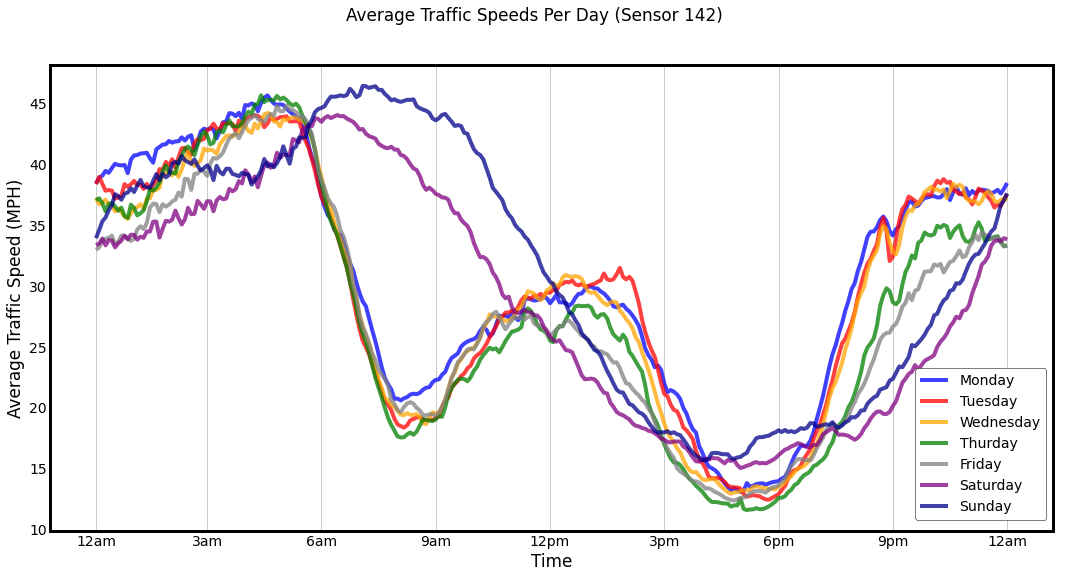

In [1402]:
fig, ax = plt.subplots(figsize=(16,8));
for i in range(7):
    colors= ['blue', 'red', 'orange', 'green', 'gray', 'purple', 'darkblue']
    weekly_trend[i]['SPEED'].plot(ax=ax, color=colors[i], alpha=0.75);
color='black'   
fig.legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thurday', 'Friday', 'Saturday', 'Sunday']
           , edgecolor='black', framealpha=1, loc=(.85,.101), facecolor='white')
fig.set_facecolor('white')
fig.suptitle('Average Traffic Speeds Per Day (Sensor 172)', color=color)
ax.grid(axis='y')
ax.set_xticks([287, 251, 215, 179, 143, 107, 71, 35, 0])
ax.set_xticklabels(['12am', '9pm', '6pm', '3pm', '12pm', '9am', '6am', '3am', '12am'], color=color)
ax.set_xlabel('Time', color=color)
ax.set_ylabel('Average Traffic Speed (MPH)', color=color)
ax.set_facecolor('white')
ax.tick_params(axis='y', colors=color)
for x in ['bottom', 'top', 'right', 'left']:
    ax.spines[x].set_color('black')
plt.show()

Yes, we can see that each day carries a unique trend that it follows. It's cool that you can clearly tell when rushhour is!

---

For the final part of eda, let's visualize where each sensor is located within NYC. To do this we first need to format the link points column in our sensor df.

In [1404]:
#lets make a dataframe only containing our sensor info
sensor_locs_df = df[['ID', 'LINK_POINTS', 'LINK_NAME']].drop_duplicates()
sensor_locs_df['LINK_POINTS'] = sensor_locs_df.apply(lambda x: x['LINK_POINTS'].split(' '), axis = 1)

In [1408]:
# Create a map using Stamen Terrain, centered on study area with set zoom level
m1 = folium.Map(location=[40.7831, -73.9712],
                   tiles='Stamen Terrain', zoom_start = 10)
# Add station markers to map
for i in range(sensor_locs_df.shape[0]):
    lat_lon = sensor_locs_df.iloc[i]['LINK_POINTS'][0].split(',')
    mouse_over_label = f'Sensor #{sensor_locs_df.iloc[i]["ID"]}\n Location:{sensor_locs_df.iloc[i]["LINK_NAME"]}'
    folium.Marker(lat_lon, tooltip=mouse_over_label).add_to(m1)

# Display map
m1
# m1.save(outfile= "test.html")
# import imgkit

# with open('test.html') as f:
#     imgkit.from_file(f, 'image.jpg')

Awesome! It looks really good and helps us visualize where we are measuring traffic flow. This is the end of the EDA notebook now that our data is cleaned and ready for modeling. In the next notebook (Modeling) we will walk through how to forecast traffic speeds for each sensor.

### Final Step (Pickling all of our hard work!)

In [1410]:
#this will save our dictionary full our cleaned sensor data
import pickle

with open('sensor_dfs.pickle', 'wb') as handle:
    pickle.dump(sensor_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

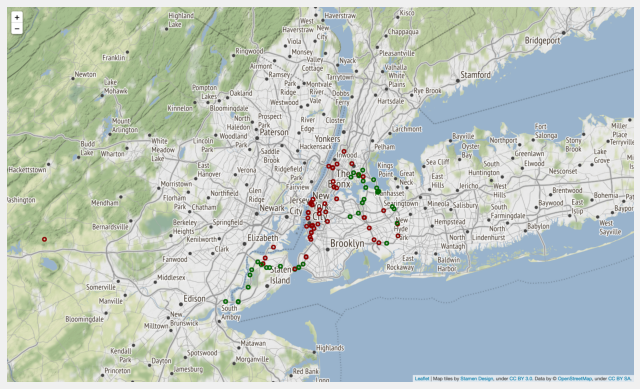

In [966]:
import matplotlib.image as mpimg
img = mpimg.imread('map.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

In [963]:
import os
import time
from selenium import webdriver

delay=5
fn='test.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Safari()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('map.png')
browser.quit()

In [37]:
poly = [   [-73.80546569824219,
              40.834333379436444
            ],
            [
              -73.86451721191406,
              40.84082704020004
            ],
            [
              -73.86211395263672,
              40.80133575979199
            ],
            [
              -73.78658294677734,
              40.803674714153786
            ],
            [
              -73.80546569824219,
              40.834333379436444]
        ]

In [39]:
# Create a map using Stamen Terrain, centered on study area with set zoom level
m = folium.Map(location=[40.7831, -73.9712],
                   tiles='Stamen Terrain', zoom_start = 10)
# Add station markers to map
for i in range(sensor_locs_df.shape[0]):
    lat_lon = sensor_locs_df.iloc[i]['LINK_POINTS'][0].split(',')
    mouse_over_label = f'Sensor #{sensor_locs_df.iloc[i].name}\n Highway:{sensor_locs_df.iloc[i]["highway"]}'
    if sensor_locs_df.iloc[i]["highway"]:
        color = 'darkgreen'
    else:
        color = 'darkred'
    folium.CircleMarker(lat_lon, tooltip=mouse_over_label, radius = 4, color = color, fill=True, fill_opacity = 0).add_to(m)

def add_marker(lat, long, color='yellow'):
    folium.CircleMarker((lat, long), radius = 4, color = color, tooltip=(lat, long), fill=True, fill_opacity = 0).add_to(m)

relevant_crashes.apply(lambda x: add_marker(x['LATITUDE'], x['LONGITUDE']), axis =1)
# Display map 
m

In [40]:
grouped.groupby(by=['ID']).mean()['mean']

ID
1      13.398569
2       9.030269
3      15.658255
4      10.451229
106    14.743089
110    45.622275
119    25.886080
124    28.569953
126    49.357975
129    53.460708
137    44.408712
140    29.880429
141    24.097783
142    45.383069
145    26.712032
148    33.046361
149    25.629455
150    16.176058
153    32.821470
154    25.887701
155    24.691128
157    30.549616
159    32.797810
160    18.594060
164    45.914456
165    46.980993
167    45.077887
168    41.071182
169    43.609765
170    42.884131
171    19.717209
172    29.064869
177    30.790909
178    44.497000
184    46.132762
185    35.799636
186     4.613052
190    25.293858
191    25.448432
195    25.856535
199    33.017523
202    44.497652
204    44.486730
205    46.821720
206    44.393169
207    46.454845
208    46.566912
211    51.131501
212    45.917291
213    31.537428
215    29.154969
217    31.109229
221    33.493866
222    37.058350
223    26.526823
257    28.354926
258    36.061230
259    23.634852
261    40.9

In [41]:
sens142 = df.query('ID == 142').sort_values(by=['DATA_AS_OF'])
sens142['rounded_timestamp'] = sens142.apply(lambda x: roundtime(dt=x['DATA_AS_OF'], roundto=5), axis=1)
sens142.tail()

ID  SPEED  TRAVEL_TIME  STATUS          DATA_AS_OF  LINK_ID  \
9396992  142  53.43          139       0 2020-10-27 22:10:10  4616261   
9397129  142  48.46          153       0 2020-10-27 22:18:12  4616261   
9397268  142  54.05          139       0 2020-10-27 22:26:11  4616261   
9397404  142  57.78          130       0 2020-10-27 22:34:12  4616261   
9397541  142  57.78          129       0 2020-10-27 22:42:11  4616261   

                                               LINK_POINTS  \
9396992  40.83037,-73.85062 40.82996,-73.849251 40.8294...   
9397129  40.83037,-73.85062 40.82996,-73.849251 40.8294...   
9397268  40.83037,-73.85062 40.82996,-73.849251 40.8294...   
9397404  40.83037,-73.85062 40.82996,-73.849251 40.8294...   
9397541  40.83037,-73.85062 40.82996,-73.849251 40.8294...   

                                         ENCODED_POLY_LINE  \
9396992  ytexFj}vaMpAqGbBgHrAgGl@sF?oEa@cGoDu\e@cGAsEF}...   
9397129  ytexFj}vaMpAqGbBgHrAgGl@sF?oEa@cGoDu\e@cGAsEF}...   
9397268  ytexFj}vaMpAqGbBgHrAgGl@sF?oEa@cGoDu\e@cGAsEF}...   
9397404  ytexFj}vaMpAqGbBgHrAgGl@sF?oEa@cGoDu\e@cGAsEF}...   
9397541  ytexFj}vaMpAqGbBgHrAgGl@sF?oEa@cGoDu\e@cGAsEF}...   

           ENCODED_POLY_LINE_LVLS        OWNER  TRANSCOM_ID BOROUGH  \
9396992  BBBBBBBBBBBBBBBBBBBBBBBB  NYC_DOT_LIC      4616261   Bronx   
9397129  BBBBBBBBBBBBBBBBBBBBBBBB  NYC_DOT_LIC      4616261   Bronx   
9397268  BBBBBBBBBBBBBBBBBBBBBBBB  NYC_DOT_LIC      4616261   Bronx   
9397404  BBBBBBBBBBBBBBBBBBBBBBBB  NYC_DOT_LIC      4616261   Bronx   
9397541  BBBBBBBBBBBBBBBBBBBBBBBB  NYC_DOT_LIC      4616261   Bronx   

                                  LINK_NAME   rounded_timestamp  
9396992  BE S Griswold - Castle Hill Avenue 2020-10-27 22:15:00  
9397129  BE S Griswold - Castle Hill Avenue 2020-10-27 22:20:00  
9397268  BE S Griswold - Castle Hill Avenue 2020-10-27 22:30:00  
9397404  BE S Griswold - Castle Hill Avenue 2020-10-27 22:35:00  
9397541  BE S Griswold - Castle Hill Avenue 2020-10-27 22:45:00

In [43]:
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
years = [2018, 2019]
datetime_array = []
for year in years:
    for month in range(1,13):
        for day in range(1,days_per_month[month-1]+1):
            for hour in range(24):
                for minute in range(0,60,5):
                    datetime_array.append(datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute))

In [44]:
days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
years_leap = [2020]
for year in years_leap:
    for month in range(1,13):
        for day in range(1,days_per_month_leap[month-1]+1):
            for hour in range(24):
                for minute in range(0,60,5):
                    datetime_array.append(datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute))

In [518]:
last_3_yrs_5min_samp_df = pd.DataFrame(datetime_array, columns=['date'])
last_3_yrs_5min_samp_df_sens142 = last_3_yrs_5min_samp_df[last_3_yrs_5min_samp_df.date <= roundtime(max(sens142.DATA_AS_OF),5)]
sens142_clean = pd.merge(left = last_3_yrs_5min_samp_df_sens142, right =  sens142, how = 'left', left_on='date', right_on='rounded_timestamp').iloc[1:]

In [519]:
sens142_clean.isnull().sum()

date                          0
ID                        26892
SPEED                     26892
TRAVEL_TIME               26892
STATUS                    26892
DATA_AS_OF                26892
LINK_ID                   26892
LINK_POINTS               26892
ENCODED_POLY_LINE         26892
ENCODED_POLY_LINE_LVLS    26892
OWNER                     26892
TRANSCOM_ID               26892
BOROUGH                   26892
LINK_NAME                 26892
rounded_timestamp         26892
dtype: int64

In [520]:
sens142_clean.sort_values(by='date', inplace = True)
sens142_clean.set_index('date', inplace = True)
sens142_clean['DATA_AS_OF'] = sens142_clean.index
sens142_clean['rounded_timestamp'] = sens142_clean.index

condition = [
                sens142_clean['SPEED'] == 0,
]
choices = [
            np.nan
]
sens142_clean['SPEED'] = np.select(condition, choices, default=sens142_clean['SPEED'])

In [521]:
sens142_clean.fillna(method = 'ffill', inplace = True)

In [522]:
sens142_clean.isnull().sum()

ID                        0
SPEED                     0
TRAVEL_TIME               0
STATUS                    0
DATA_AS_OF                0
LINK_ID                   0
LINK_POINTS               0
ENCODED_POLY_LINE         0
ENCODED_POLY_LINE_LVLS    0
OWNER                     0
TRANSCOM_ID               0
BOROUGH                   0
LINK_NAME                 0
rounded_timestamp         0
dtype: int64

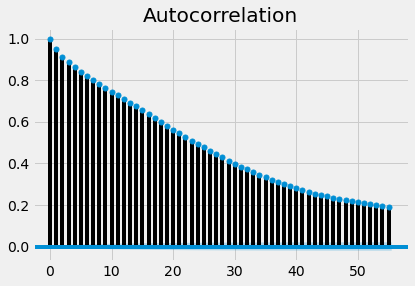

In [538]:
#ACF/PACF to determine which terms to include (MA or AR or Both?)
from statsmodels.graphics.tsaplots import plot_acf
#plot autocorrelation for each lag (alpha is confidence interval)
plot_acf(sens142_clean['SPEED'], alpha=.05);

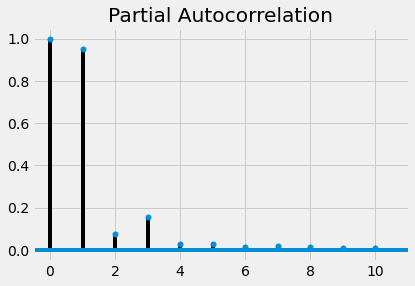

In [539]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(sens142_clean['SPEED'], alpha=.05, lags=10);

In [88]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(sens142_clean.iloc[:288]['SPEED'], order=(2,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/krk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:                  SPEED   No. Observations:                  288
Model:                     ARMA(2, 3)   Log Likelihood                -767.798
Method:                       css-mle   S.D. of innovations              3.475
Date:                Sun, 01 Nov 2020   AIC                           1549.596
Time:                        14:07:20   BIC                           1575.237
Sample:                    01-01-2018   HQIC                          1559.872
                         - 01-02-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          54.0453      1.102     49.057      0.000      51.886      56.205
ar.L1.SPEED     1.3463      0.540      2.493      0.013       0.288       2.405
ar.L2.SPEED    -0.3652      0.523     -0.699    

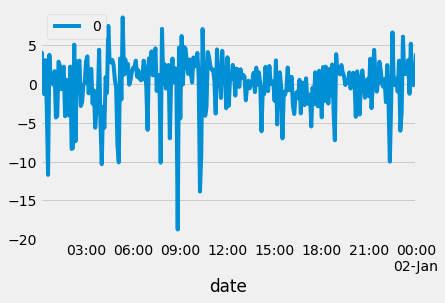

In [89]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

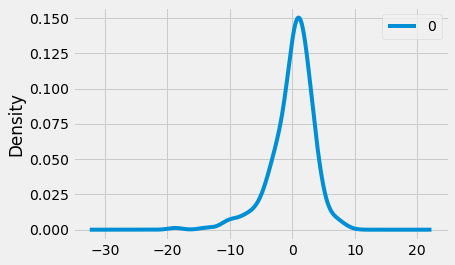

In [90]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

plt.show()

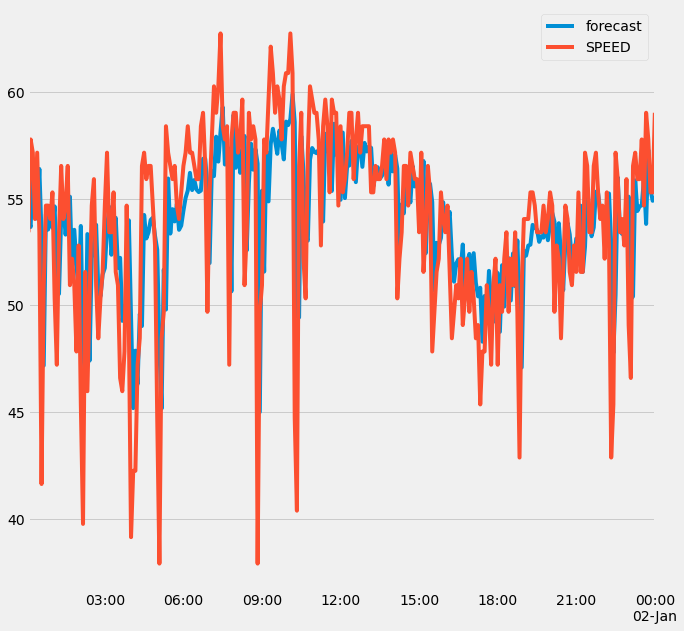

In [542]:
fig, ax = plt.subplots(figsize=(10,10))
model_fit.plot_predict(ax=ax);
ax.set_alpha(0.1)

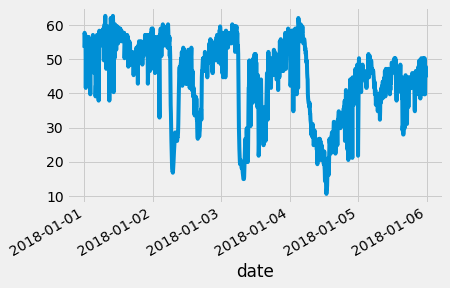

In [541]:
sens142_clean.iloc[:1440]['SPEED'].plot()

In [543]:
X_steps = 1440
y_steps = 72

In [544]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_dfs(dataframe = sens142_clean, column = 'SPEED', X_steps = X_steps, y_steps = y_steps)

## Baseline

In [558]:
y_pred = X_val_std[:, -y_steps:]

In [560]:
np.mean(mean_squared_error(y_val_std, y_pred))

0.2539470442866927

In [548]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(y_steps)
])

model.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model.fit(X_train, y_train, epochs = 20)

Epoch 1/20
5/5 [==============================] - 0s 906us/step - loss: 3147.3645
Epoch 2/20
5/5 [==============================] - 0s 839us/step - loss: 1613.4885
Epoch 3/20
5/5 [==============================] - 0s 870us/step - loss: 898.0536
Epoch 4/20
5/5 [==============================] - 0s 1ms/step - loss: 706.5485
Epoch 5/20
5/5 [==============================] - 0s 905us/step - loss: 508.1600
Epoch 6/20
5/5 [==============================] - 0s 1ms/step - loss: 441.7001
Epoch 7/20
5/5 [==============================] - 0s 1ms/step - loss: 358.8530
Epoch 8/20
5/5 [==============================] - 0s 810us/step - loss: 317.7578
Epoch 9/20
5/5 [==============================] - 0s 934us/step - loss: 286.3949
Epoch 10/20
5/5 [==============================] - 0s 1ms/step - loss: 258.7963
Epoch 11/20
5/5 [==============================] - 0s 1ms/step - loss: 237.0979
Epoch 12/20
5/5 [==============================] - 0s 1ms/step - loss: 227.9388
Epoch 13/20
5/5 [==================

In [549]:
model.evaluate(X_val, y_val)

2/2 [==============================] - 0s 1ms/step - loss: 101.6323


101.63227081298828

## Deep RNN

In [550]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(10),
    keras.layers.Dense(y_steps, activation='relu')
])

model2.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model2.fit(X_train, y_train, epochs = 20)

Epoch 1/20
5/5 [==============================] - 1s 199ms/step - loss: 2464.0212
Epoch 2/20
5/5 [==============================] - 1s 183ms/step - loss: 2460.9927
Epoch 3/20
5/5 [==============================] - 1s 184ms/step - loss: 2457.6924
Epoch 4/20
5/5 [==============================] - 1s 183ms/step - loss: 2454.4641
Epoch 5/20
5/5 [==============================] - 1s 193ms/step - loss: 2451.1931
Epoch 6/20
5/5 [==============================] - 1s 185ms/step - loss: 2447.9756
Epoch 7/20
5/5 [==============================] - 1s 182ms/step - loss: 2444.5566
Epoch 8/20
5/5 [==============================] - 1s 182ms/step - loss: 2440.9712
Epoch 9/20
5/5 [==============================] - 1s 181ms/step - loss: 2437.2544
Epoch 10/20
5/5 [==============================] - 1s 181ms/step - loss: 2433.3638
Epoch 11/20
5/5 [==============================] - 1s 183ms/step - loss: 2429.3059
Epoch 12/20
5/5 [==============================] - 1s 180ms/step - loss: 2424.9634
Epoch 13/20
5

In [551]:
model2.evaluate(X_val, y_val)

2/2 [==============================] - 0s 24ms/step - loss: 2495.4341


2495.43408203125

In [552]:
X_train_std, y_train_std, X_val_std, y_val_std, X_test_std, y_test_std = train_val_test_dfs(dataframe = sens142_clean, column = 'SPEED', X_steps = X_steps, y_steps = y_steps, standardize=True)

In [554]:
model3 = keras.models.Sequential([
    keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(30),
    keras.layers.Dense(y_steps, activation='relu')
])

model3.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model3.fit(X_train_std, y_train_std, epochs = 20)

Epoch 1/20
5/5 [==============================] - 1s 220ms/step - loss: 0.6631
Epoch 2/20
5/5 [==============================] - 1s 194ms/step - loss: 0.6383
Epoch 3/20
5/5 [==============================] - 1s 188ms/step - loss: 0.6159
Epoch 4/20
5/5 [==============================] - 1s 184ms/step - loss: 0.5955
Epoch 5/20
5/5 [==============================] - 1s 193ms/step - loss: 0.5800
Epoch 6/20
5/5 [==============================] - 1s 187ms/step - loss: 0.5641
Epoch 7/20
5/5 [==============================] - 1s 196ms/step - loss: 0.5535
Epoch 8/20
5/5 [==============================] - 1s 185ms/step - loss: 0.5442
Epoch 9/20
5/5 [==============================] - 1s 187ms/step - loss: 0.5370
Epoch 10/20
5/5 [==============================] - 1s 190ms/step - loss: 0.5307
Epoch 11/20
5/5 [==============================] - 1s 185ms/step - loss: 0.5296
Epoch 12/20
5/5 [==============================] - 1s 188ms/step - loss: 0.5245
Epoch 13/20
5/5 [==============================] 

In [555]:
model3.evaluate(X_val_std, y_val_std)

2/2 [==============================] - 0s 27ms/step - loss: 0.1318


0.13180150091648102

In [679]:
model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dense(y_steps, activation='tanh')
])

model4.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model4.fit(X_train_std, y_train_std, epochs = 11)

Epoch 1/11
5/5 [==============================] - 0s 3ms/step - loss: 0.6716
Epoch 2/11
5/5 [==============================] - 0s 3ms/step - loss: 0.4595
Epoch 3/11
5/5 [==============================] - 0s 3ms/step - loss: 0.3572
Epoch 4/11
5/5 [==============================] - 0s 3ms/step - loss: 0.3195
Epoch 5/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2678
Epoch 6/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2322
Epoch 7/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2088
Epoch 8/11
5/5 [==============================] - 0s 4ms/step - loss: 0.1966
Epoch 9/11
5/5 [==============================] - 0s 3ms/step - loss: 0.1979
Epoch 10/11
5/5 [==============================] - 0s 3ms/step - loss: 0.1768
Epoch 11/11
5/5 [==============================] - 0s 3ms/step - loss: 0.1661


In [680]:
model4.evaluate(X_val_std, y_val_std)

2/2 [==============================] - 0s 910us/step - loss: 0.1958


0.19575545191764832

In [681]:
model4.save('best_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model/assets


In [867]:
model5 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(500, activation='tanh'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(y_steps, activation='tanh')
])

model5.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

history = model5.fit(X_train_std, y_train_std, epochs = 11)

Epoch 1/11
5/5 [==============================] - 0s 3ms/step - loss: 0.7207
Epoch 2/11
5/5 [==============================] - 0s 4ms/step - loss: 0.4725
Epoch 3/11
5/5 [==============================] - 0s 4ms/step - loss: 0.4054
Epoch 4/11
5/5 [==============================] - 0s 4ms/step - loss: 0.3366
Epoch 5/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2902
Epoch 6/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2711
Epoch 7/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2466
Epoch 8/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2257
Epoch 9/11
5/5 [==============================] - 0s 3ms/step - loss: 0.2146
Epoch 10/11
5/5 [==============================] - 0s 4ms/step - loss: 0.2033
Epoch 11/11
5/5 [==============================] - 0s 3ms/step - loss: 0.1967


In [872]:
history.history['loss'][-1]

0.19665847718715668

In [860]:
model5.evaluate(X_val_std, y_val_std)

2/2 [==============================] - 0s 956us/step - loss: 0.2951


0.2950737774372101

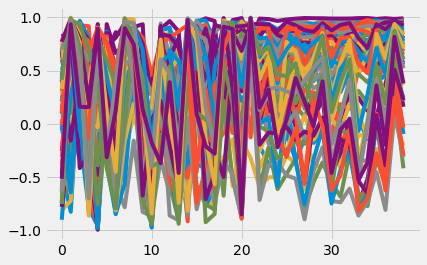

In [1135]:
plt.plot(model5.predict(X_val_std));

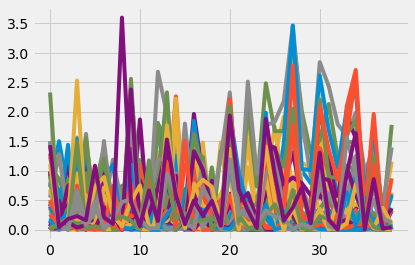

In [1132]:
plt.plot(((model5.predict(X_val_std) - y_val_std[:, :, 0]) ** 2));

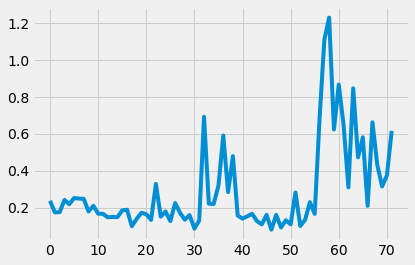

In [1130]:
plt.plot(((model5.predict(X_val_std) - y_val_std[:, :, 0]) ** 2).mean(axis=0))

In [504]:
def forecast_sets(y_train, y_val, y_test):
    df = pd.concat([X_train, y_train, X_val, y_val, X_test, y_test])
    num_obs = X_train.shape[0] * (X_train.shape[1] + y_train.shape[1]) + X_val.shape[0] * (X_val.shape[1] + y_val.shape[1]) + X_test.shape[0] * (X_test.shape[1] + y_test.shape[1])
    Y = np.empty(num_obs, X_train.shape[1], y_train.shape[1])
    for step_ahead in range(1, y_train.shape[1] + 1):
        Y[:, :, step_ahead - 1] = df[:, step_ahead: ]
    return num_obs

In [505]:
forecast_sets(X_train_std, y_train_std, X_val_std, y_val_std, X_test_std, y_test_std)

296352

In [702]:
sens142_clean['SPEED'].mean()

45.63688570718342

In [704]:
sens142_clean['SPEED'].std() * 0.3

3.7576328757074977

In [1099]:
def sensor_etl(df, ID, filename, start_year = 2019, end_year = 2020):
    """
    
    
    """
    #file suffix
    if start_year == end_year:
        suffix = str(start_year)
    else:
        suffix = str(start_year) + '_' + str(end_year)
        
    #import libraries
    from IPython.display import clear_output
    
    #query of dataframe by the ID input and sort values by date
    sens = df.query('ID == @ID').sort_values(by=['DATA_AS_OF'])
    
    #add column to the sensor df with the rounded 5-min time intervals
    sens['rounded_timestamp'] = sens.apply(lambda x: roundtime(dt=x['DATA_AS_OF'], roundto= 5), axis=1)
 
    #make array of years of data wanted
    years = [x for x in range(start_year,end_year + 1)]
    
    #turn sensor df into a dataframe with rows for all the missing time 5min time periods
    sampling_df = last_x_yrs_5min_samp_df(years)
    sens_sampling_df = sampling_df[(sampling_df.date >= sens.head(1)['rounded_timestamp'].iloc[0]) & (sampling_df.date <= sens.tail(1)['rounded_timestamp'].iloc[0])]
    sens_clean = pd.merge(left = sens_sampling_df, right =  sens, how = 'left', left_on='date', right_on='rounded_timestamp').iloc[1:]

    #fill the missing values using forward fill and reset the index to the date column
    sens_clean.sort_values(by='date', inplace = True)
    sens_clean.set_index('date', inplace = True)
    sens_clean['DATA_AS_OF'] = sens_clean.index
    sens_clean['rounded_timestamp'] = sens_clean.index

    #fill the speed column values of 0 with the previous value. This is to make our model more sensitive to outliers for anomaly detection
    condition = [sens_clean['SPEED'] == 0]
    choices = [np.nan]
    sens_clean['SPEED'] = np.select(condition, choices, default=sens_clean['SPEED'])
    sens_clean.fillna(method = 'ffill', inplace = True)

    # Group the time series into weekly buckets
    sens_weekly = sens_clean['SPEED'].resample('7D')

    # Take the mean of each group 
    sens_weekly_mean = sens_weekly.mean()
    
    #plot the generic trend and save the figure
    fig1, ax1 = plt.subplots(figsize=(16,8))
    sens_weekly_mean.plot(color='blue', ax=ax1);
    fig1.set_facecolor('white')
    fig1.suptitle('Weekly Traffic Speeds (' + filename + ')')
    ax1.grid(axis='y')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average Traffic Speed (MPH)')
    ax1.set_facecolor('white')
    for x in ['bottom', 'top', 'right', 'left']:
        ax1.spines[x].set_color('black')
    
    plt.savefig(filename + '_weekly_trend_' + suffix, bbox_inches='tight', facecolor='white')
    plt.close()

    #aggregate all of the data to each weekday and plot that data
    weekly_agg = day_of_week_agg(sens_clean)

    fig2, ax2 = plt.subplots(figsize=(16,8));
    for i in range(7):
        colors= ['blue', 'red', 'orange', 'green', 'gray', 'purple', 'darkblue']
        weekly_agg[i]['SPEED'].plot(ax=ax2, color=colors[i], alpha=0.75);
    color='black'   
    fig2.legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thurday', 'Friday', 'Saturday', 'Sunday']
               , edgecolor='black', framealpha=1, loc=(.85,.101), facecolor='white')
    fig2.set_facecolor('white')
    fig2.suptitle('Average Traffic Speeds Per Day (' + filename + ')', color=color)
    ax2.grid(axis='y')
    ax2.set_xticks([287, 251, 215, 179, 143, 107, 71, 35, 0])
    ax2.set_xticklabels(['12am', '9pm', '6pm', '3pm', '12pm', '9am', '6am', '3am', '12am'], color=color)
    ax2.set_xlabel('Time', color=color)
    ax2.set_ylabel('Average Traffic Speed (MPH)', color=color)
    ax2.set_facecolor('white')
    ax2.tick_params(axis='y', colors=color)
    for x in ['bottom', 'top', 'right', 'left']:
        ax2.spines[x].set_color('black')
    plt.savefig(filename + '_weekdays_' + suffix, bbox_inches='tight', facecolor='white')
    plt.close()

    #make the df stationary
    sens_clean = pd.DataFrame(sens_clean['SPEED'].copy().diff(2016))
    sens_clean.dropna(inplace = True)

    #number of steps to train on and predict on
    X_steps = 1440
    y_steps = 72

    #standardize data and split into train, val and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_dfs(dataframe = sens_clean, column = 'SPEED', X_steps = X_steps, y_steps = y_steps, standardize=True)

    #------MODELING------
    #Baseline
    y_pred = X_val[:, -y_steps:]

    baseline_loss = np.mean(mean_squared_error(y_val, y_pred))

#     #Vanilla Model
#     model1 = keras.models.Sequential([
#         keras.layers.Flatten(input_shape=[X_steps, 1]),
#         keras.layers.Dense(y_steps)
#     ])
#     model1.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 1/5')
#     history1 = model1.fit(X_train, y_train, epochs = 20)
#     train_loss1 = history1.history['loss'][-1]
#     val_loss1 = model1.evaluate(X_val, y_val)
#     clear_output(wait=True)
    
#     ## Deep RNN
#     model2 = keras.models.Sequential([
#         keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
#         keras.layers.SimpleRNN(10),
#         keras.layers.Dense(y_steps, activation='relu')
#     ])
#     model2.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 2/5')
#     history2 = model2.fit(X_train, y_train, epochs = 20)
#     train_loss2 = history2.history['loss'][-1]
#     val_loss2 = model2.evaluate(X_val, y_val)
#     clear_output(wait=True)

#     model3 = keras.models.Sequential([
#         keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 1]),
#         keras.layers.SimpleRNN(30),
#         keras.layers.Dense(y_steps, activation='relu')
#     ])
#     model3.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 3/5')
#     history3 = model3.fit(X_train, y_train, epochs = 20)
#     train_loss3 = history3.history['loss'][-1]
#     val_loss3 = model3.evaluate(X_val, y_val)
#     clear_output(wait=True)
    
    #fully connected neural nets
    model4 = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_steps, 1]),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dense(y_steps, activation='tanh')
    ])
    model4.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 4/5')
    history4 = model4.fit(X_train_std, y_train_std, epochs = 11, verbose=0)
    train_loss4 = history4.history['loss'][-1]
    val_loss4 = model4.evaluate(X_val_std, y_val_std, verbose=0)
    clear_output(wait=True)

    model5 = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_steps, 1]),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(y_steps, activation='tanh')
    ])
    model5.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 5/5')
    history5 = model5.fit(X_train_std, y_train_std, epochs = 11, verbose=0)
    train_loss5 = history5.history['loss'][-1]
    val_loss5 = model5.evaluate(X_val_std, y_val_std, verbose=0)
    clear_output(wait=True)
    
#     print(f'---Baseline---')
#     print(f'training loss: {baseline_loss:.3f} testing loss: {baseline_loss:.3f}')
#     print(f'---Vanilla---(Model 1)')
#     print(f'training loss: {train_loss1:.3f} testing loss: {val_loss1:.3f}')
#     print(f'---RNN (10 neurons)---(Model 2)')
#     print(f'training loss: {train_loss2:.3f} testing loss: {val_loss2:.3f}')
#     print(f'---RNN (30 neurons)---(Model 3)')
#     print(f'training loss: {train_loss3:.3f} testing loss: {val_loss3:.3f}')
#     print(f'---NN (1 dropout layer)---(Model 4)')
#     print(f'training loss: {train_loss4:.3f} testing loss: {val_loss4:.3f}')
#     print(f'---NN (3 dropout layers)---(Model 5)')
#     print(f'training loss: {train_loss5:.3f} testing loss: {val_loss5:.3f}')
    
    if val_loss5 < val_loss4:
        use_model = 5
    elif ((val_loss5 - train_loss5) < (val_loss4 - train_loss4)) & ((val_loss4 - train_loss4) - (val_loss5 - train_loss5) > (val_loss5 - val_loss4)):
        use_model = 5
    else:
        use_model = 4
    
    c.execute(f'''
                    INSERT INTO MODEL_PERFORMANCE_2015_2020 (sensor_id,
                                                   model4_train_loss,
                                                   model4_test_loss,
                                                   model5_train_loss,
                                                   model5_test_loss,
                                                   final_model)
                                VALUES ({ID},
                                        {train_loss4},
                                        {val_loss4},
                                        {train_loss5},
                                        {val_loss5},
                                        {use_model})

              ''')
    
    conn.commit()
    
    if use_model == 1:
        model1.save(filename + '_model_' + suffix)
    elif use_model == 2:
        model2.save(filename + '_model_' + suffix)
    elif use_model == 3:
        model3.save(filename + '_model_' + suffix)
    elif use_model == 4:
        model4.save(filename + '_model_' + suffix)
    else:
        model5.save(filename + '_model_' + suffix)
      
    clear_output(wait=True)

In [967]:
df['ID'].unique()

array([165, 313, 453, 167, 212, 205, 318, 211, 319, 206, 213, 395, 347,
       141, 140, 398, 202, 298, 124, 119, 402, 406, 365, 364, 316, 380,
       417, 379, 416, 411, 264, 410, 263, 325, 324, 349, 330, 329, 399,
       376, 375, 381, 369, 350, 441, 436, 387, 385, 430, 431, 383, 258,
       261, 129, 126, 295, 338, 137, 142, 425, 257, 262, 106,   3, 222,
       450, 332, 169, 170, 448, 445, 168, 164, 451, 311, 440, 265, 195,
       345, 186, 344, 191, 190, 377, 378, 435, 384, 439, 437, 390, 185,
       351, 388, 434, 433, 382, 259, 154, 155, 153, 428, 159, 184, 148,
       427, 160, 157, 426, 110, 178, 422, 423, 424, 177, 172, 204,   2,
       217, 215, 221,   1,   4, 149, 150, 223, 145, 208, 199, 207, 331,
       171, 315, 405, 394, 419, 418, 412, 413, 354])

In [1100]:
import tqdm
start_year = 2015
end_year = 2020
ids = list(df[(df['DATA_AS_OF'] > str(start_year)) & (df['DATA_AS_OF'] < str(end_year + 1))]['ID'].unique())
# index = ids.index(2)
# ids = ids[index+1:]
for x in tqdm.tqdm(ids):
    sensor_etl(df, x, 'Sensor' + str(x), start_year, end_year)

100%|██████████| 139/139 [32:29<00:00, 14.02s/it]


In [1093]:
ids[45]

2

In [1002]:
import sqlite3
import pandas as pd
from pandas import DataFrame

conn = sqlite3.connect('traffic_flow.db')
c = conn.cursor()

In [1097]:
# Create table - MODEL_PERFORMANCE
c.execute('''CREATE TABLE MODEL_PERFORMANCE_2015_2020
             ([sensor_id] INTEGER PRIMARY KEY,
             [model1_train_loss] float,
             [model1_test_loss] float,
             [model2_train_loss] float,
             [model2_test_loss] float,
             [model3_train_loss] float,
             [model3_test_loss] float,
             [model4_train_loss] float,
             [model4_test_loss] float,
             [model5_train_loss] float,
             [model5_test_loss] float,
             [final_model] integer)''')
          

In [1136]:
conn.commit()

In [1044]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('MODEL_PERFORMANCE',)]


In [1083]:
c.execute("DELETE FROM MODEL_PERFORMANCE ")

In [1084]:
conn.commit()

In [1137]:
conn.close()

In [1077]:
train_loss4 = 1.6
val_loss4 = 2.3
train_loss5 = 2.2
val_loss5 = 2.6

In [1078]:
if val_loss5 < val_loss4:
    use_model = 5
elif ((val_loss5 - train_loss5) < (val_loss4 - train_loss4)) & ((val_loss4 - train_loss4) - (val_loss5 - train_loss5) > (val_loss5 - val_loss4)):
    use_model = 5
else:
    use_model = 4
use_model

4

In [1096]:
df[(df['DATA_AS_OF'] > '2015') & (df['DATA_AS_OF'] < '2021')].shape

(36716526, 13)

In [1108]:
stand = df
condition = [stand['SPEED'] == 0]
choices = [np.nan]
stand['SPEED'] = np.select(condition, choices, default=stand['SPEED'])
stand.fillna(method = 'ffill', inplace = True)

<ipython-input-1108-884710fc8fc3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stand['SPEED'] = np.select(condition, choices, default=stand['SPEED'])
/Users/krk/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [1110]:
stand['SPEED'].mean()

40.024755200751216

In [1115]:
stand['SPEED'].std() * 0.3

4.802734997237477